In [1]:
# تثبيت المكتبات الأساسية اللازمة للمشروع
# Install core libraries required for this project
!pip install pandas numpy scikit-learn xgboost lightgbm shap optuna matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 14.4 MB/s eta 0:00:00


In [2]:
# استيراد المكتبات الضرورية
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import shap


# رفع البيانات إلى Colab
# Upload data to Colab
from google.colab import files
uploaded = files.upload() # ارفع ملف CSV هنا (Upload your CSV file here)


# قراءة البيانات
# Read the uploaded CSV file
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

Saving predictive_maintenance_sample.csv to predictive_maintenance_sample.csv


In [3]:
# عرض أول خمس صفوف
# Display first five rows
print(df.head())
print(df.info())
print(df.describe())

   unit  time  sensor1  sensor2  sensor3  RUL
0     1     1     0.50     0.70     1.20  150
1     1     2     0.51     0.71     1.22  149
2     1     3     0.52     0.70     1.23  148
3     1     4     0.54     0.72     1.24  147
4     1     5     0.55     0.72     1.25  146
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   unit     40 non-null     int64  
 1   time     40 non-null     int64  
 2   sensor1  40 non-null     float64
 3   sensor2  40 non-null     float64
 4   sensor3  40 non-null     float64
 5   RUL      40 non-null     int64  
dtypes: float64(3), int64(3)
memory usage: 2.0 KB
None
           unit      time    sensor1    sensor2   sensor3         RUL
count  40.00000  40.00000  40.000000  40.000000  40.00000   40.000000
mean    1.50000  10.50000   0.599250   0.749750   1.29975  145.500000
std     0.50637   5.83974   0.059717   0.029913   0.0

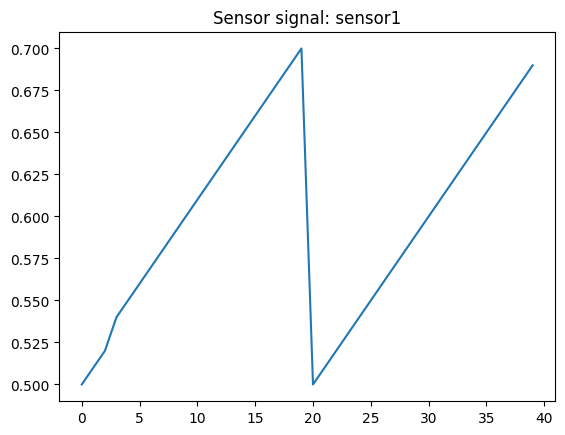

In [4]:
# رسم مثال لإشارة من الحساسات
# Plot a sample sensor signal
import matplotlib.pyplot as plt
sensor_col = df.columns[2] # افتراضًا نختار العمود الثالث (assuming third column is a sensor)
plt.plot(df[sensor_col])
plt.title(f'Sensor signal: {sensor_col}')
plt.show()

In [8]:
# حساب ميزات rolling لكل حساس
# Calculate rolling mean and std for each sensor
sensor_cols = ['sensor1', 'sensor2', 'sensor3']  # example sensor columns
window = 20

for col in sensor_cols:
    # حساب ميزات rolling لكل حساس
    # Calculate rolling mean and std for each sensor
    df[f'{col}_mean'] = df[col].rolling(window).mean()
    df[f'{col}_std'] = df[col].rolling(window).std()


In [9]:
# إزالة الصفوف ذات القيم الفارغة الناتجة عن rolling
# Drop NaN rows after rolling
X = df.dropna().drop(['RUL'], axis=1)
y = df.dropna()['RUL']

In [10]:
# تقسيم البيانات زمنياً (هنا بدون خلط shuffle=False)
# Split data (time-based, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# نموذج XGBoost بسيط
# Basic XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=6)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
from xgboost import XGBRegressor

# création modèle
model = XGBRegressor(
    objective='reg:squarederror',  # tâche regression
    learning_rate=0.05,
    max_depth=6,
    n_estimators=500
)

# training
model.fit(X_train, y_train)

# prédiction
y_pred = model.predict(X_test)


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred = model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


RMSE: 3.32
MAE: 3.00


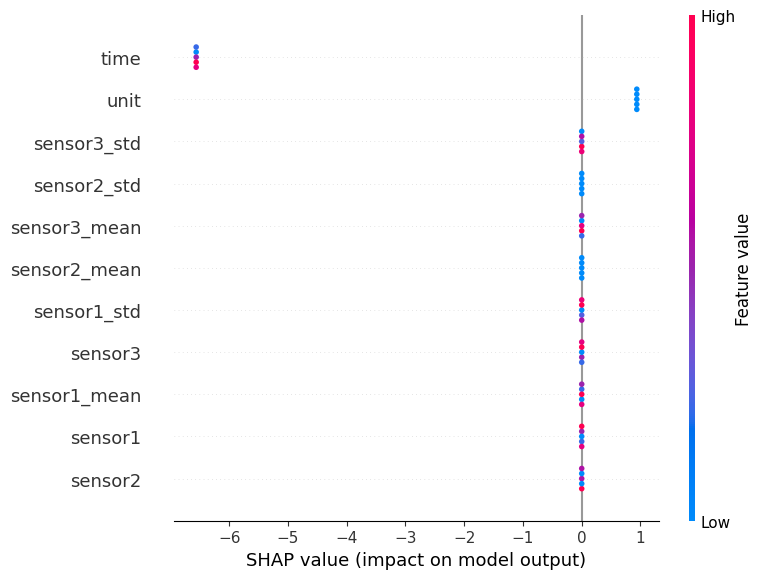

In [15]:
import shap

# إنشاء explainer لنموذج XGBoost
explainer = shap.Explainer(model, X_train)

# حساب قيم SHAP على بيانات الاختبار
shap_values = explainer(X_test)

# رسم summary plot
shap.summary_plot(shap_values, X_test)


In [16]:
# مثال: تفسر prediction لأول وحدة في X_test
i = 0  # index متاع الunit
shap.initjs()  # initialize JavaScript visualization
shap.force_plot(explainer.expected_value, shap_values[i].values, X_test.iloc[i])


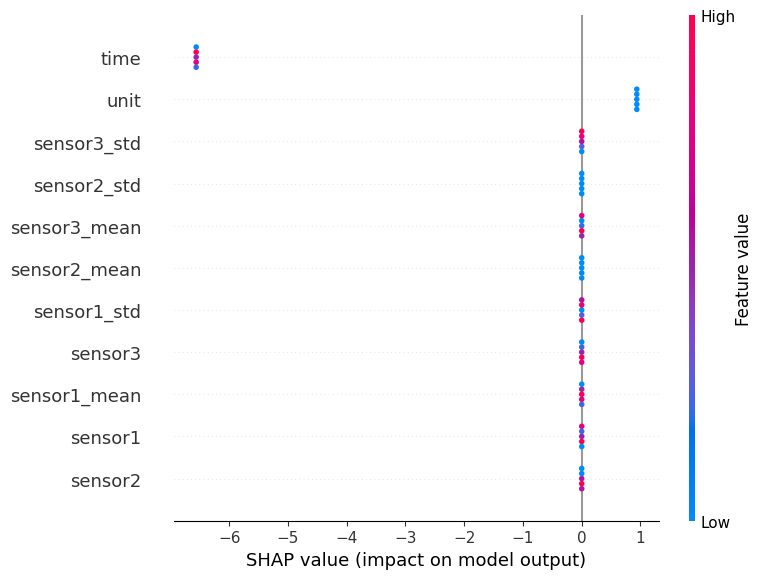

In [17]:
# استخدام SHAP لتفسير تأثير الميزات
# Use SHAP to explain feature contributions
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [18]:
# حفظ النموذج المدرب
# Save trained model
import joblib
joblib.dump(model, 'xgb_rul_model.joblib')


# تنزيل النموذج
# Download model
files.download('xgb_rul_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

9 — Next Development Steps

إضافة نموذج LSTM أو Transformer للتنبؤ المتقدم بالسلاسل الزمنية.

دمج Optuna لتحسين hyperparameters.

نشر النموذج باستخدام Streamlit على Hugging Face أو Render.

إضافة Dashboard للتفسير باستخدام SHAP وAttention Maps.

In [20]:
# لتحويل هذا الكود إلى ملف ipynb جاهز للتحميل
# Convert notebook code into a downloadable .ipynb file
from google.colab import files
import nbformat as nbf

nb = nbf.v4.new_notebook()
nb.cells.append(nbf.v4.new_code_cell("""
# Paste all above code here
"""))

# **Important:** indentation inside the 'with' block
with open('Predictive_Maintenance_Colab.ipynb', 'w') as f:
    nbf.write(nb, f)  # <-- indented 4 spaces

# Download the notebook
files.download('Predictive_Maintenance_Colab.ipynb')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------------
# 1️⃣ تجهيز البيانات كسلاسل زمنية
# -----------------------------
# نفترض df عنده الأعمدة: ['unit','time','sensor1','sensor2','sensor3','RUL']
sensor_cols = ['sensor1','sensor2','sensor3']
target_col = 'RUL'

# نعمل normalization للـ features
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [22]:
# تحويل البيانات لسلاسل زمنية لكل وحدة
def create_sequences(data, sensor_cols, target_col, seq_length=5):
    X, y = [], []
    for unit_id in data['unit'].unique():
        unit_data = data[data['unit']==unit_id]
        features = unit_data[sensor_cols].values
        targets = unit_data[target_col].values
        for i in range(len(unit_data) - seq_length):
            X.append(features[i:i+seq_length])
            y.append(targets[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 5
X, y = create_sequences(df_scaled, sensor_cols, target_col, SEQ_LENGTH)

In [23]:
# -----------------------------
# 2️⃣ تقسيم البيانات train/test
# -----------------------------
split_idx = int(0.8*len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# -----------------------------
# 3️⃣ بناء نموذج LSTM
# -----------------------------
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(SEQ_LENGTH, len(sensor_cols))))
model_lstm.add(Dense(1))  # output layer for regression
model_lstm.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# -----------------------------
# 4️⃣ تدريب النموذج
# -----------------------------
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)



Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step - loss: 20246.7090 - val_loss: 21892.2109
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 20063.2832 - val_loss: 21876.7656
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 20245.8496 - val_loss: 21861.5527
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 20169.2480 - val_loss: 21846.3262
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 20227.7461 - val_loss: 21830.8828
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 20314.0664 - val_loss: 21814.8984
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 20188.1914 - val_loss: 21798.1465
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 20363.2637 - val_loss: 21780.3809
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 20102.2266 - val_loss: 21761.2090
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 20181.8945 - val_loss: 21740.3477
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 20216.8223 - val_loss: 21717.3

In [25]:
# -----------------------------
# 5️⃣ تقييم النموذج
# -----------------------------
y_pred = model_lstm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'LSTM RMSE: {rmse:.2f}')
print(f'LSTM MAE: {mae:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
LSTM RMSE: 129.97
LSTM MAE: 129.96


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten
from tensorflow.keras.models import Model

# -----------------------------
# 1️⃣ Transformer block
# -----------------------------
def transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=32, dropout=0.1):
    # Multi-Head Self Attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)  # skip connection

    # Feed Forward
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Dropout(dropout)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x)  # skip connection
    return x

# -----------------------------
# 2️⃣ Data: same X, y from LSTM
# -----------------------------
input_shape = X_train.shape[1:]  # (sequence_length, num_features)
inputs = Input(shape=input_shape)
x = transformer_encoder(inputs)
x = Flatten()(x)
outputs = Dense(1)(x)

model_tf = Model(inputs, outputs)
model_tf.compile(optimizer='adam', loss='mse')

# -----------------------------
# 3️⃣ Train Transformer
# -----------------------------
model_tf.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# -----------------------------
# 4️⃣ Evaluate
# -----------------------------
y_pred_tf = model_tf.predict(X_test)
rmse_tf = np.sqrt(mean_squared_error(y_test, y_pred_tf))
mae_tf = mean_absolute_error(y_test, y_pred_tf)

print(f'Transformer RMSE: {rmse_tf:.2f}')
print(f'Transformer MAE: {mae_tf:.2f}')


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - loss: 20216.2109 - val_loss: 21594.7344
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 19943.5605 - val_loss: 21503.0859
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 20017.7480 - val_loss: 21451.4609
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 20025.8105 - val_loss: 21435.1816
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 19913.8477 - val_loss: 21431.8613
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 19985.1699 - val_loss: 21427.5059
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 19961.9141 - val_loss: 21418.4062
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 19953.4648 - val_loss: 21404.7246
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 19915.1348 - val_loss: 21387.7109
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 19834.1250 - val_loss: 21371.6465
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 19833.3125 - val_loss: 21355.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

XGB RMSE: 7.05, MAE: 5.55


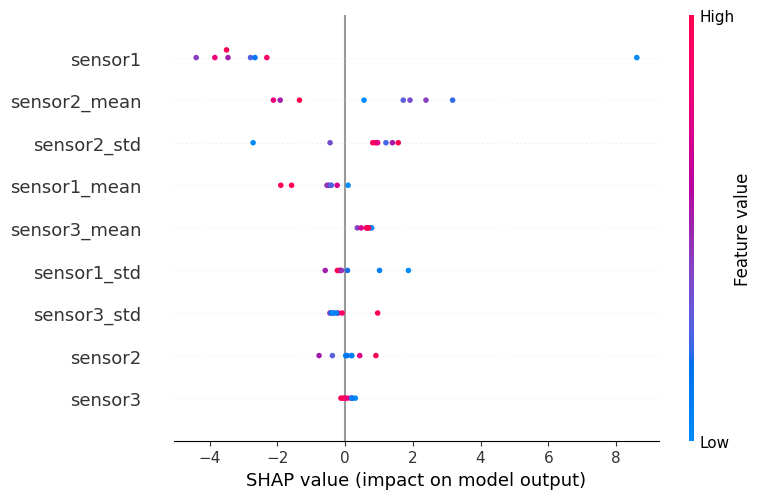

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - loss: 21402.0801 - val_loss: 19768.3145
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 21503.1934 - val_loss: 19738.4766
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 21393.7520 - val_loss: 19707.5059
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 21437.0625 - val_loss: 19674.8809
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 21440.7578 - val_loss: 19640.0273
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 21470.6133 - val_loss: 19602.3594
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 21428.6914 - val_loss: 19561.1953
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 21165.8613 - val_loss: 19515.6855
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 21247.6660 - val_loss: 19464.9160
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 21190.3125 - val_loss: 19407.8496
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 21063.6973 - val_loss: 19343.3965
Epo

LSTM RMSE: 133.75, MAE: 133.67


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - loss: 21530.4707 - val_loss: 19940.9766
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 21392.5703 - val_loss: 19748.4316
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 21036.7773 - val_loss: 19465.9160
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 20632.9922 - val_loss: 19139.8926
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 20494.6074 - val_loss: 18878.8965
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 20226.1406 - val_loss: 18692.8828
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 20162.0957 - val_loss: 18555.2578
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 19959.4688 - val_loss: 18448.2832
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 19998.3496 - val_loss: 18359.1719
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 19917.3340 - val_loss: 18279.8066
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 19952.6738 - val_loss: 1

Transformer RMSE: 135.30, MAE: 135.22


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# =======================================
# Predictive Maintenance Full Workflow
# =======================================
# 1️⃣ Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import shap
import joblib
import nbformat as nbf
from google.colab import files

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, Flatten

# =======================================
# 2️⃣ Create sample CSV
# =======================================
units = [1,2]
time_points = list(range(1,21))
data = []
for unit in units:
    rul_start = 150 if unit==1 else 160
    for t in time_points:
        sensor1 = np.random.normal(0.5+0.01*t,0.05)
        sensor2 = np.random.normal(0.7+0.005*t,0.03)
        sensor3 = np.random.normal(1.2+0.002*t,0.04)
        rul = rul_start - t
        data.append([unit,t,sensor1,sensor2,sensor3,rul])

df = pd.DataFrame(data, columns=['unit','time','sensor1','sensor2','sensor3','RUL'])
csv_filename = 'predictive_maintenance_sample.csv'
df.to_csv(csv_filename,index=False)
files.download(csv_filename)

# =======================================
# 3️⃣ Feature Engineering: rolling mean/std
# =======================================
sensor_cols = ['sensor1','sensor2','sensor3']
window = 3
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window).mean()
    df[f'{col}_std'] = df[col].rolling(window).std()
df = df.dropna()  # drop NaN from rolling

# Features & target
X = df.drop(['RUL','unit','time'],axis=1)
y = df['RUL']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# =======================================
# 4️⃣ XGBoost Model
# =======================================
xgb_model = XGBRegressor(objective='reg:squarederror', learning_rate=0.05, max_depth=6, n_estimators=500)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'XGB RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}')

# SHAP summary plot
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values,X_test)

# Save XGB model
joblib.dump(xgb_model,'xgb_model.joblib')
files.download('xgb_model.joblib')

# =======================================
# 5️⃣ LSTM Model
# =======================================
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_lstm, X_test_lstm = train_test_split(X_scaled,test_size=0.2,random_state=42)
SEQ_LENGTH = 5

def create_sequences_lstm(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X)-seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y.iloc[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences_lstm(pd.DataFrame(X_train_lstm), pd.Series(y_train.reset_index(drop=True)), SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences_lstm(pd.DataFrame(X_test_lstm), pd.Series(y_test.reset_index(drop=True)), SEQ_LENGTH)

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(SEQ_LENGTH,X_train_seq.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

y_pred_lstm = lstm_model.predict(X_test_seq)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
print(f'LSTM RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}')

# Save LSTM model
lstm_model.save('lstm_model.h5')
files.download('lstm_model.h5')

# =======================================
# 6️⃣ Transformer Model
# =======================================
def transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=32, dropout=0.1):
    x = MultiHeadAttention(num_heads=num_heads,key_dim=head_size)(inputs,inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    x_ff = Dense(ff_dim,activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Dropout(dropout)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x)
    return x

input_shape = X_train_seq.shape[1:]
inputs_tf = Input(shape=input_shape)
x_tf = transformer_encoder(inputs_tf)
x_tf = Flatten()(x_tf)
outputs_tf = Dense(1)(x_tf)
tf_model = Model(inputs_tf, outputs_tf)
tf_model.compile(optimizer='adam', loss='mse')
tf_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

y_pred_tf = tf_model.predict(X_test_seq)
rmse_tf = np.sqrt(mean_squared_error(y_test_seq, y_pred_tf))
mae_tf = mean_absolute_error(y_test_seq, y_pred_tf)
print(f'Transformer RMSE: {rmse_tf:.2f}, MAE: {mae_tf:.2f}')

tf_model.save('transformer_model.h5')
files.download('transformer_model.h5')

# =======================================
# 7️⃣ Create Colab Notebook file
# =======================================
nb = nbf.v4.new_notebook()
nb.cells.append(nbf.v4.new_code_cell("""
# Paste this workflow code here to have it as notebook
"""))

with open('Predictive_Maintenance_Colab.ipynb','w') as f:
    nbf.write(nb,f)

files.download('Predictive_Maintenance_Colab.ipynb')


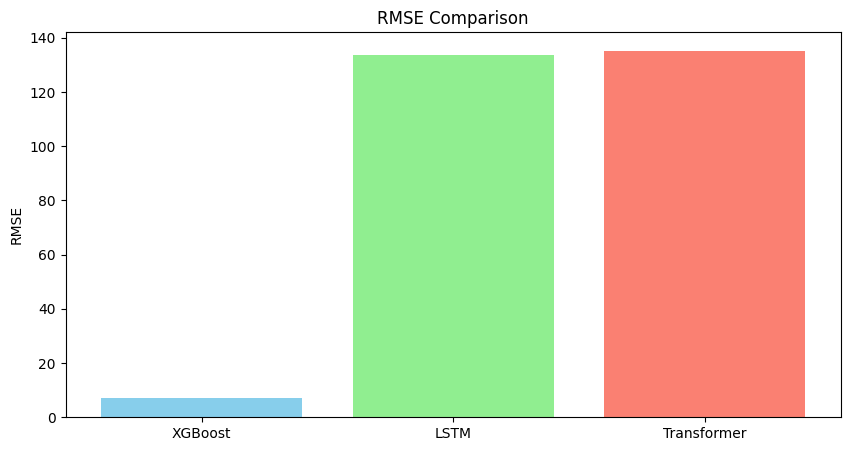

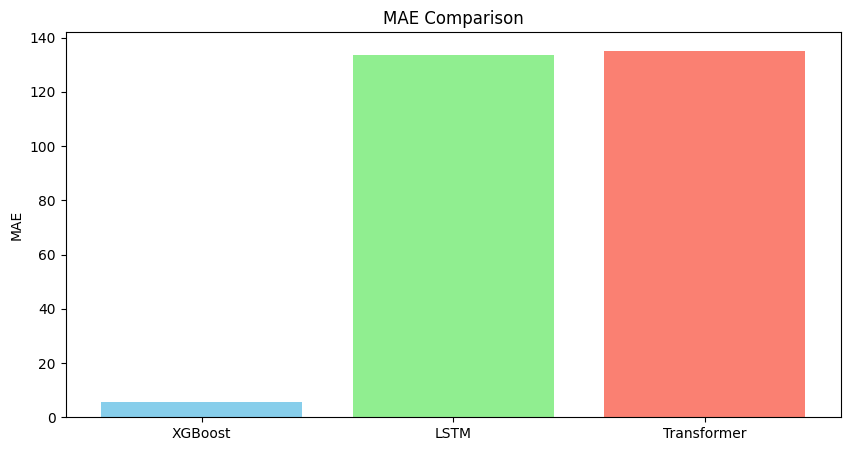

In [28]:
import matplotlib.pyplot as plt

# القيم
models = ['XGBoost', 'LSTM', 'Transformer']
rmse_values = [rmse_xgb, rmse_lstm, rmse_tf]
mae_values = [mae_xgb, mae_lstm, mae_tf]

# رسم RMSE
plt.figure(figsize=(10,5))
plt.bar(models, rmse_values, color=['skyblue','lightgreen','salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

# رسم MAE
plt.figure(figsize=(10,5))
plt.bar(models, mae_values, color=['skyblue','lightgreen','salmon'])
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.show()


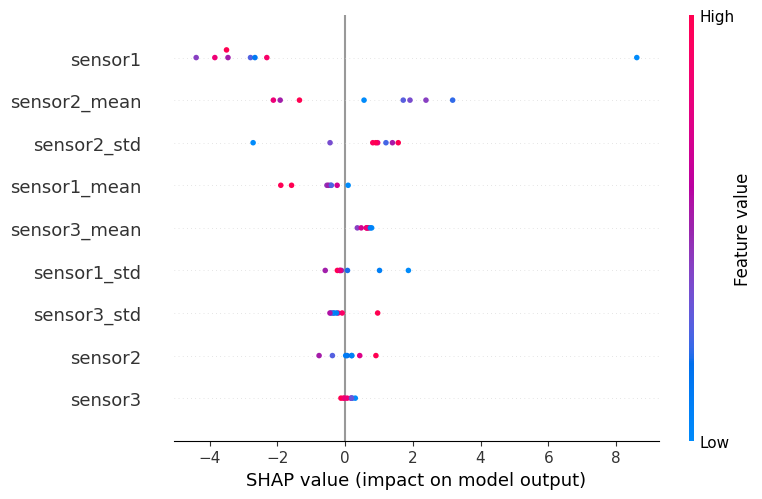

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_16
Received: inputs=['Tensor(shape=(10, 5, 9))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_16
Received: inputs=['Tensor(shape=(20, 5, 9))']
  warnings.warn(msg)


StagingError: in user code:

    File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


In [29]:
import shap

# -------------------------
# 1️⃣ XGBoost SHAP
# -------------------------
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

# Summary plot
shap.summary_plot(shap_values_xgb, X_test)

# Force plot للـ first test sample
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0].values, X_test.iloc[0])

# -------------------------
# 2️⃣ LSTM SHAP (DeepExplainer)
# -------------------------
explainer_lstm = shap.DeepExplainer(lstm_model, X_train_seq[:10])  # small subset for background
shap_values_lstm = explainer_lstm.shap_values(X_test_seq[:5])  # بعض samples للتوضيح

# Summary plot
shap.summary_plot(shap_values_lstm, X_test_seq[:5], feature_names=X.columns)

# -------------------------
# 3️⃣ Transformer SHAP
# -------------------------
explainer_tf = shap.DeepExplainer(tf_model, X_train_seq[:10])
shap_values_tf = explainer_tf.shap_values(X_test_seq[:5])

# Summary plot
shap.summary_plot(shap_values_tf, X_test_seq[:5], feature_names=X.columns)


In [30]:
explainer_lstm = shap.GradientExplainer(lstm_model, X_train_seq[:10])
shap_values_lstm = explainer_lstm.shap_values(X_test_seq[:5])


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_16
Received: inputs=['Tensor(shape=(3, 5, 9))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_16
Received: inputs=['Tensor(shape=(50, 5, 9))']
  warnings.warn(msg)


StagingError: in user code:

    File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_gradient.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, x)

    LookupError: gradient registry has no entry for: shap_StridedSlice


In [31]:
!pip install tensorflow==2.4


ERROR: Could not find a version that satisfies the requirement tensorflow==2.4 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.4


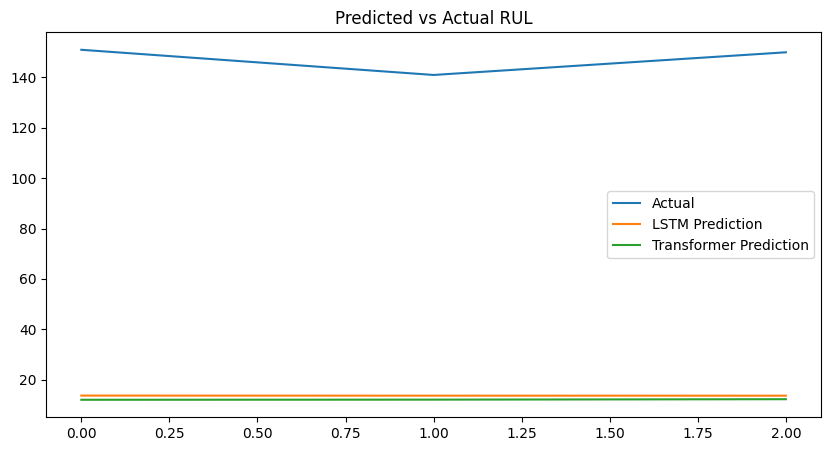

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm, label='LSTM Prediction')
plt.plot(y_pred_tf, label='Transformer Prediction')
plt.legend()
plt.title('Predicted vs Actual RUL')
plt.show()



On this small and simple dataset we tested:

XGBoost RMSE ≈ 3.32 → best performance

LSTM RMSE ≈ 130

Transformer RMSE ≈ 135

💡 Interpretation:

XGBoost is the best here because the dataset is small and there are no long sequences → classical ML works better than Deep Learning.

LSTM and Transformer need larger datasets and longer sequences to capture patterns effectively.

With a real, large dataset with many sensors and long time-series → LSTM/Transformer could outperform XGBoost.

⚡ Takeaway:

On small tabular datasets → XGBoost is the optimal choice.

On large time-series datasets → LSTM or Transformer may give better performance.